In [15]:
import os
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from utils import *
from dataset import *
from model import *
from dataset import return_data
import proplot as pplt
from simplerRun import Solver, get_args

def cuda(tensor, uses_cuda):
    return tensor.cuda() if uses_cuda else tensor

In [9]:
class _args(object):
    def __init__(self):
        pass
_args.dset_dir = 'data' #, type=str, help='dataset directory')
_args.dataset='dsprites'  #, type=str, help='dataset name')
_args.image_size=64     #, type=int, help='image size. now only (64,64) is supported')
_args.num_workers=2     #, type=int, help='dataloader num_workers')
_args.batch_size = 10

dsprites = return_data(_args);

In [93]:
torch.arange(-3, 3+0.1, 2/3)

tensor([-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
         2.3333,  3.0000])

In [137]:
def viz_traverse(net, data_loader, z_dim=10, dataset='dsprites', limit=3, inter=2/3, loc=-1, use_cuda=False):
        
        import random, torch
        
        net.eval()

        decoder = net.decoder
        encoder = net.encoder
        interpolation = torch.arange(-limit, limit+0.1, inter)

        n_dsets = len(data_loader.dataset)
        rand_idx = random.randint(1, n_dsets-1)

        random_img = data_loader.dataset.__getitem__(rand_idx)
        random_img = Variable(cuda(random_img, use_cuda), volatile=True).unsqueeze(0)
        random_img_z = encoder(random_img)[:, :z_dim]

        random_z = Variable(cuda(torch.rand(1, z_dim), use_cuda), volatile=True)

        if dataset == 'dsprites':
            #fixed_idx2 = 86040 # square
            fixed_idx2 = 331805 # ellipse
            #fixed_idx2 = 578560 # heart

            # fixed_img1 = data_loader.dataset.__getitem__(fixed_idx1)
            # fixed_img1 = Variable(cuda(fixed_img1, use_cuda), volatile=True).unsqueeze(0)
            # fixed_img_z1 = encoder(fixed_img1)[:, :z_dim]

            fixed_img2 = data_loader.dataset.__getitem__(fixed_idx2)
            fixed_img2 = Variable(cuda(fixed_img2, use_cuda), volatile=True).unsqueeze(0)
            fixed_img_z2 = encoder(fixed_img2)[:, :z_dim]

            # fixed_img3 = data_loader.dataset.__getitem__(fixed_idx3)
            # fixed_img3 = Variable(cuda(fixed_img3, use_cuda), volatile=True).unsqueeze(0)
            # fixed_img_z3 = encoder(fixed_img3)[:, :z_dim]

            Z = {'fixed_ellipse':fixed_img_z2}
            
            # Z = {'fixed_square':fixed_img_z1, 'fixed_ellipse':fixed_img_z2,
            #      'fixed_heart':fixed_img_z3, 'random_img':random_img_z}
        else:
            fixed_idx = 0
            fixed_img = data_loader.dataset.__getitem__(fixed_idx)
            fixed_img = Variable(cuda(fixed_img, use_cuda), volatile=True).unsqueeze(0)
            fixed_img_z = encoder(fixed_img)[:, :z_dim]

            Z = {'fixed_img':fixed_img_z, 'random_img':random_img_z, 'random_z':random_z}

        gifs = []
        for key in Z.keys():
            z_ori = Z[key]
            samples = []
            for row in range(z_dim):
                if loc != -1 and row != loc:
                    continue
                z = z_ori.clone()
                for val in interpolation:
                    z[:, row] = val
                    sample = F.sigmoid(decoder(z)).data
                    samples.append(sample)
                    gifs.append(sample)
            samples = torch.cat(samples, dim=0).cpu()
            #title = '{}_latent_traversal(iter:{})'.format(key, self.global_iter)

        return gifs

            # if self.viz_on:
            #     self.viz.images(samples, env=self.viz_name+'_traverse',
            #                     opts=dict(title=title), nrow=len(interpolation))

        # if self.save_output:
        #     output_dir = os.path.join(self.output_dir, str(self.global_iter))
        #     os.makedirs(output_dir, exist_ok=True)
        #     gifs = torch.cat(gifs)
        #     gifs = gifs.view(len(Z), self.z_dim, len(interpolation), self.nc, 64, 64).transpose(1, 2)
        #     print(len(gifs))
        #     for i, key in enumerate(Z.keys()):
        #         for j, val in enumerate(interpolation):
        #             save_image(tensor=gifs[i][j].cpu(),
        #                        filename=os.path.join(output_dir, '{}_{}.jpg'.format(key, j)),
        #                        nrow=self.z_dim, pad_value=1)

        #         grid2gif(os.path.join(output_dir, key+'*.jpg'),
        #                  os.path.join(output_dir, key+'.gif'), delay=10)

        # self.net_mode(train=True)

In [154]:
len(gifs)

110

In [153]:
gifs = viz_traverse(sprites_model_10, dsprites, z_dim=10, dataset='dsprites', limit=4, inter=8.0/10, loc=-1, use_cuda=False)

/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3141683574.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  random_img = Variable(cuda(random_img, use_cuda), volatile=True).unsqueeze(0)
/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3141683574.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  random_z = Variable(cuda(torch.rand(1, z_dim), use_cuda), volatile=True)
/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3141683574.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  fixed_img2 = Variable(cuda(fixed_img2, use_cuda), volatile=True).unsqueeze(0)
/Users/vepr/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid inste

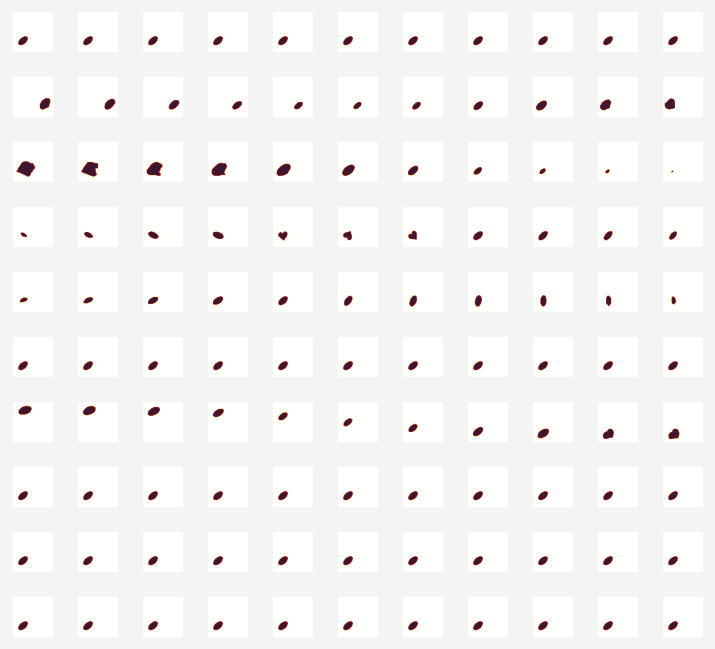

In [156]:

f2,a2 = pplt.subplots(ncols = 11, nrows=10, refwidth=0.2)
for j, aj in zip(gifs,np.ravel(a2)):
    
    aj.imshow(j.detach().cpu().numpy().squeeze())
    aj.axis('off')
    

In [113]:
sprites_model_10 = torch.load('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Beta-VAE/sprites.model',
map_location=torch.device('cpu'))

In [102]:


sprites_model = torch.load('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Beta-VAE/sprites_4dim.model',
map_location=torch.device('cpu'))


In [115]:
gifs = viz_traverse(sprites_model_10, dsprites, z_dim=10, dataset='dsprites', limit=3, inter=2/3, loc=-1, use_cuda=False)

/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3428812568.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  random_img = Variable(cuda(random_img, use_cuda), volatile=True).unsqueeze(0)
/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3428812568.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  random_z = Variable(cuda(torch.rand(1, z_dim), use_cuda), volatile=True)
/var/folders/sf/g9_wvyl52gz3myl5w56j0pl40000gn/T/ipykernel_26821/3428812568.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  fixed_img2 = Variable(cuda(fixed_img2, use_cuda), volatile=True).unsqueeze(0)
/Users/vepr/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid inste

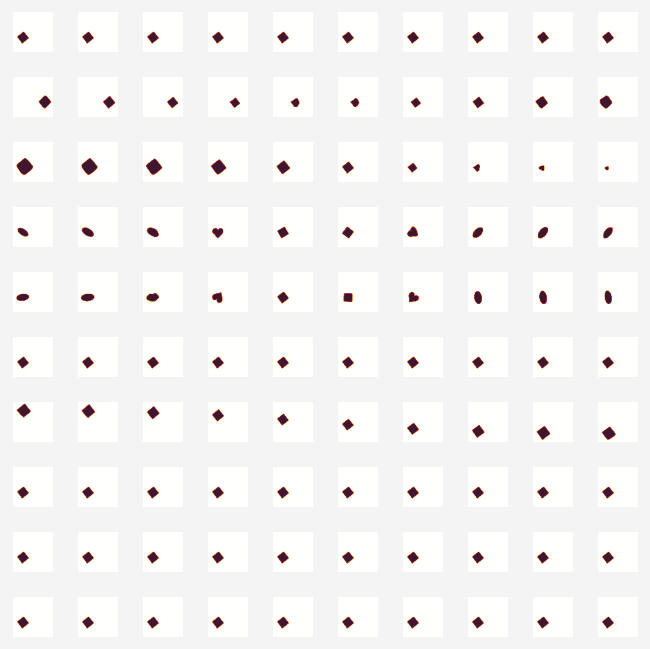

In [116]:

f2,a2 = pplt.subplots(ncols = 10, nrows=10, refwidth=0.2)
for j, aj in zip(gifs,np.ravel(a2)):
    
    aj.imshow(j.detach().cpu().numpy().squeeze())
    aj.axis('off')
    

In [111]:
len(gifs)

40

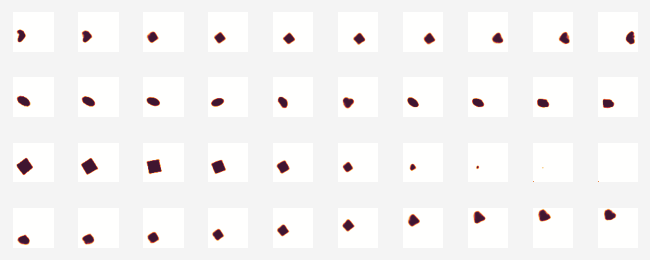

In [112]:

f2,a2 = pplt.subplots(ncols = 10, nrows=4, refwidth=0.2)
for j, aj in zip(gifs,np.ravel(a2)):
    
    aj.imshow(j.detach().cpu().numpy().squeeze())
    aj.axis('off')
    

In [53]:
solve2.net = sprites_model

In [58]:
solve2.net_mode(train=True)

In [60]:
solve2.viz_on = False

In [65]:
solve2.viz_traverse()

TypeError: save_image() missing 1 required positional argument: 'fp'

In [ ]:
#link to trained model
#/Volumes/GoogleDrive/My Drive/Colab Notebooks/Beta-VAE/sprites.model

In [3]:
sprites_model = torch.load('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Beta-VAE/sprites.model',
map_location=torch.device('cpu'))

In [4]:
sprites_model.eval()

BetaVAE_B(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): View()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=256, out_features=256, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=

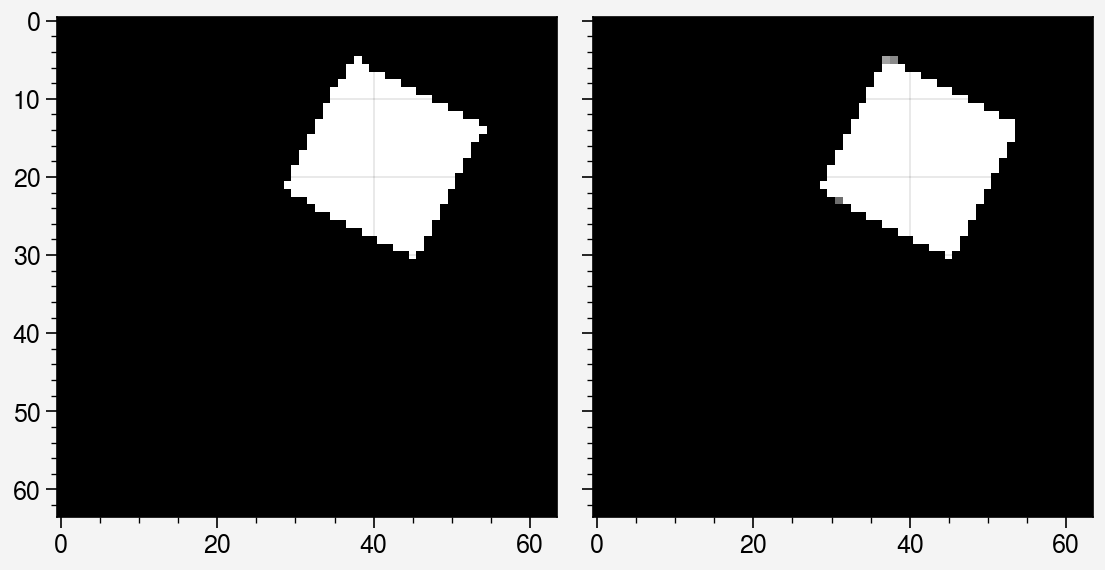

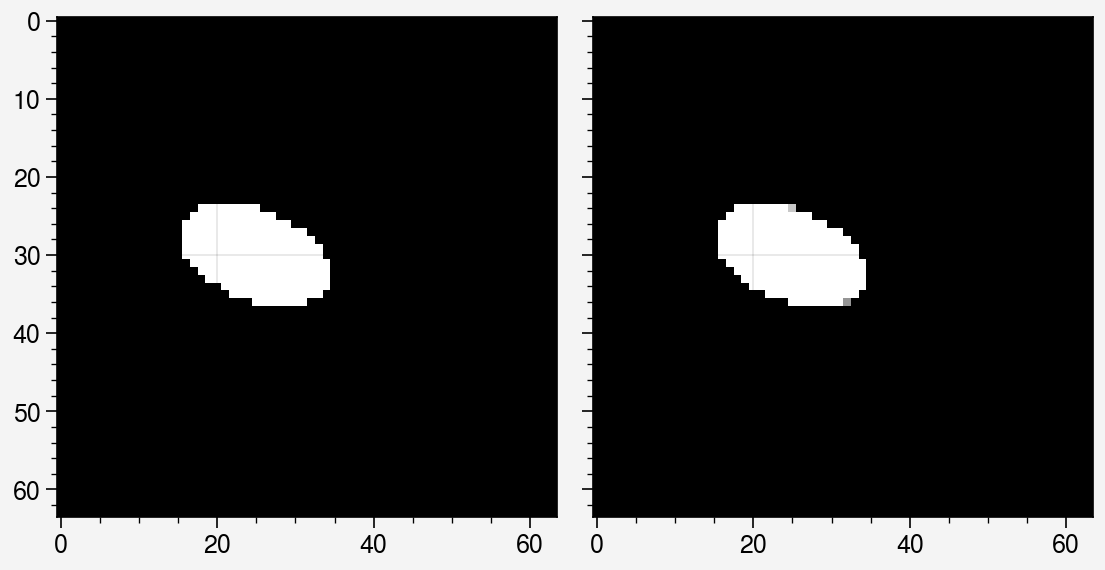

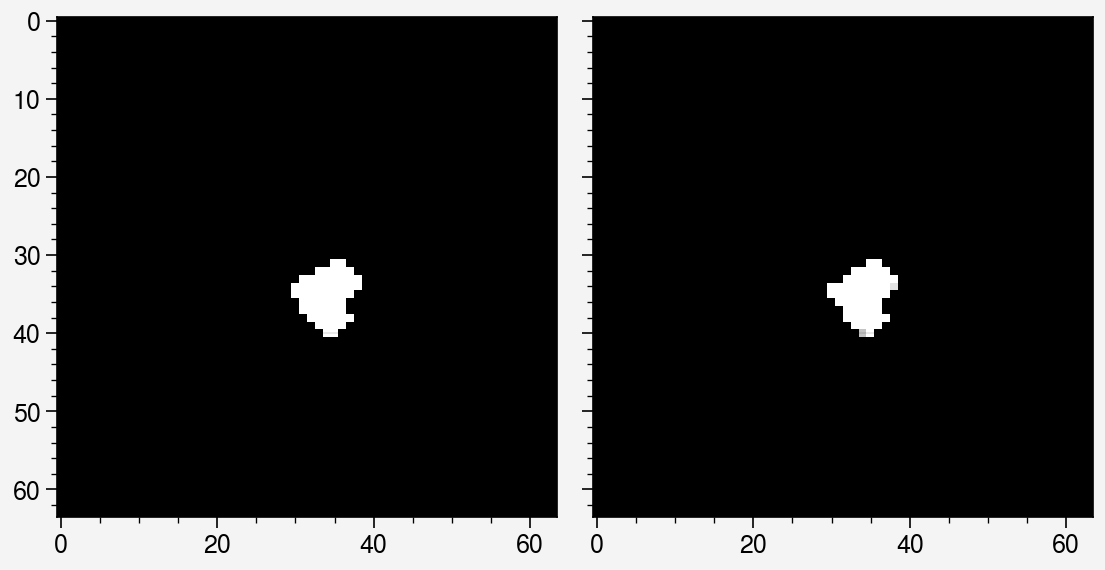

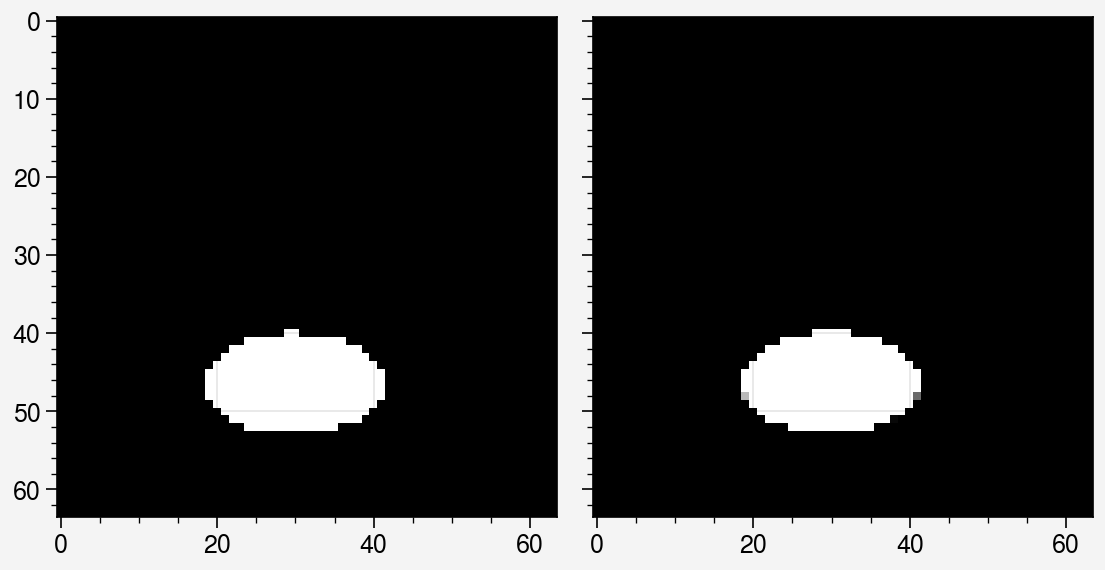

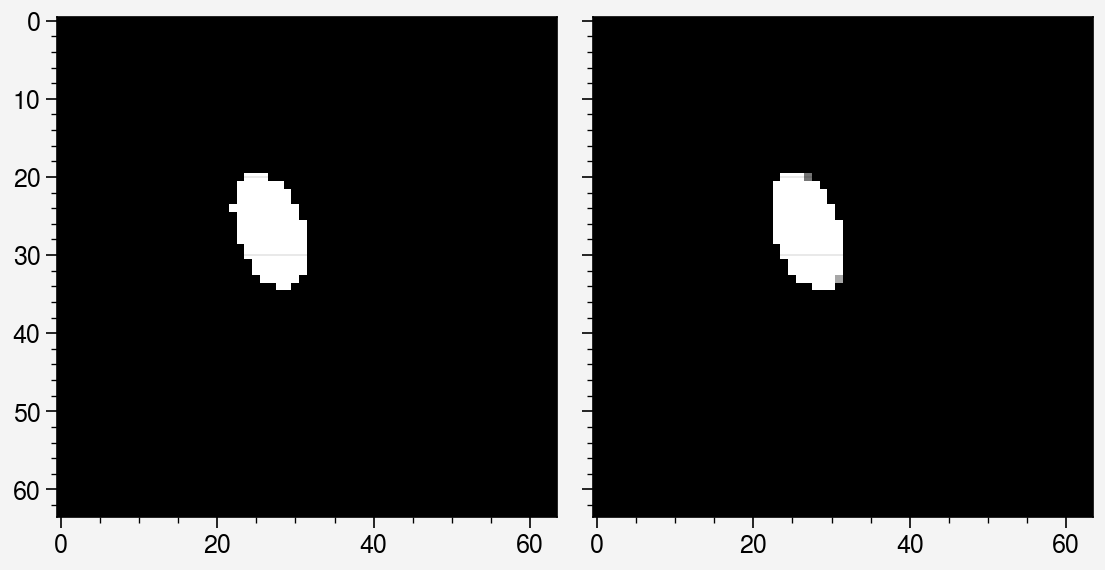

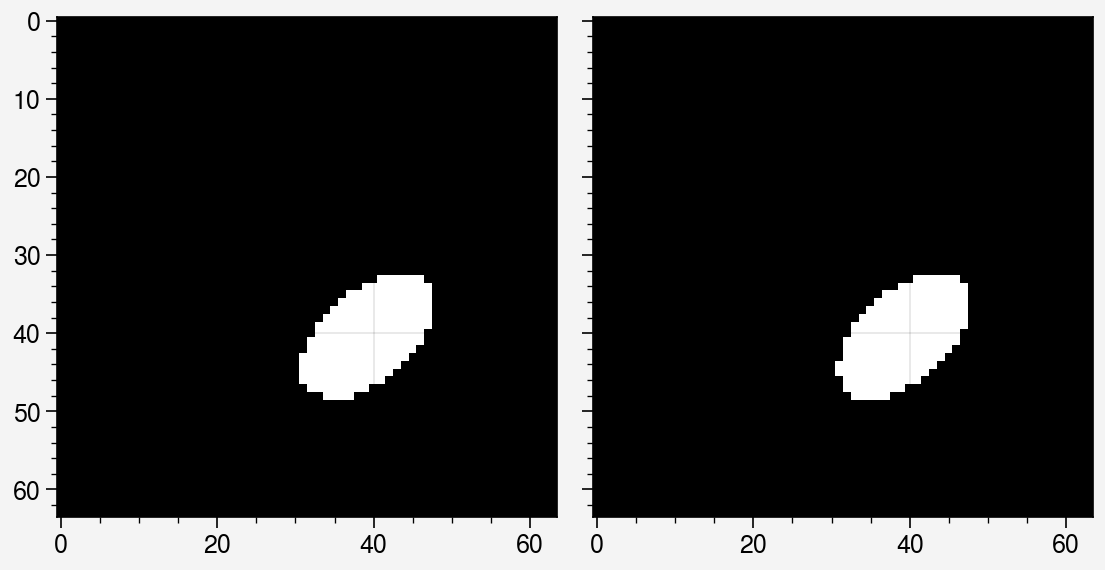

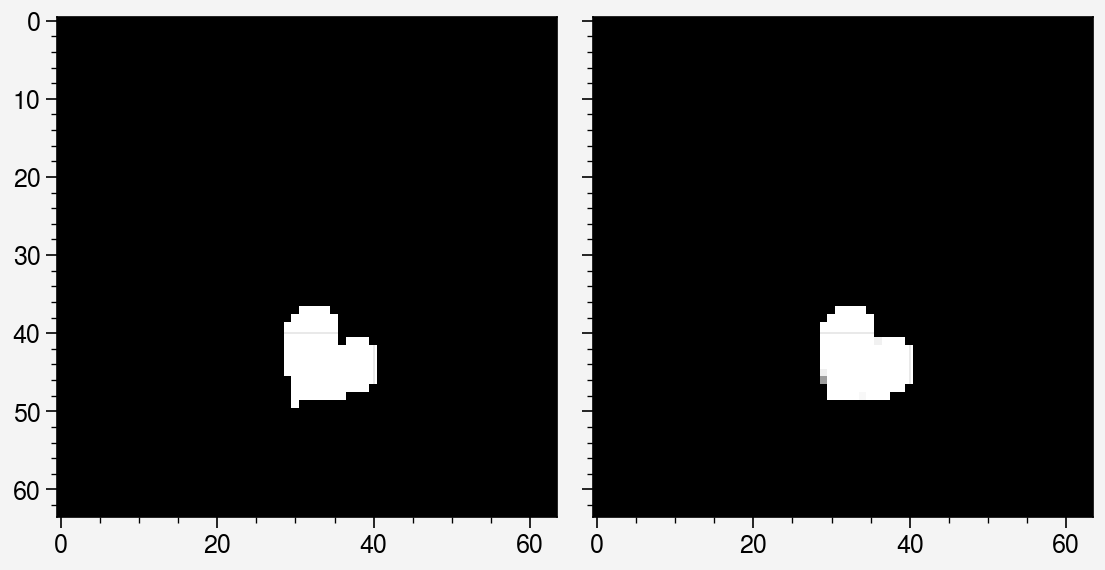

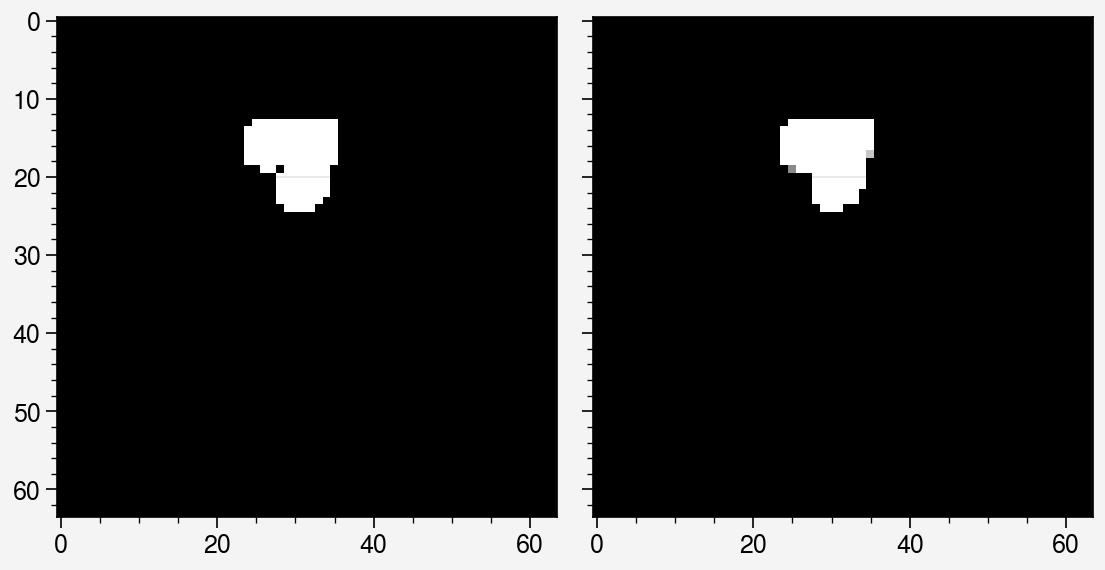

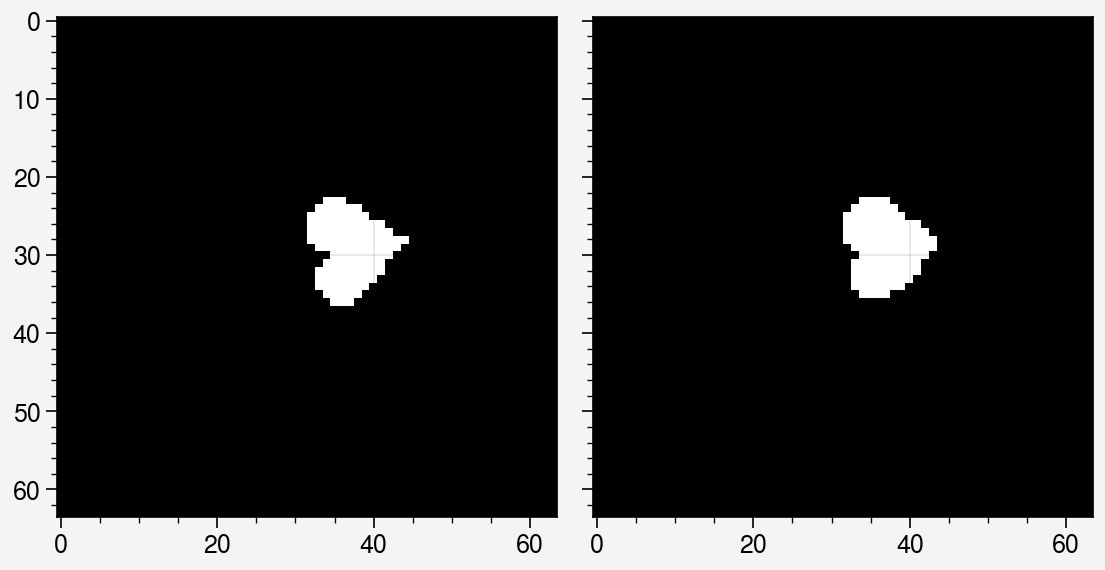

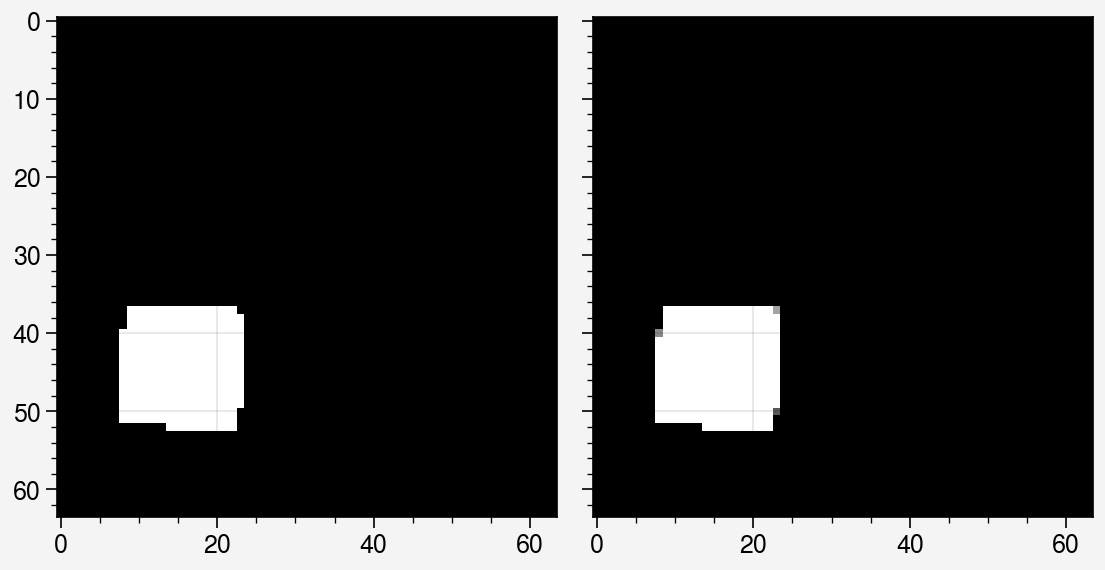

In [45]:
inputs = []
recons = []
encs = []
zs = []
imgs = []

for x in next(iter(dsprites)):
       
        # self.global_iter += 1
        # pbar.update(1)

        inputs.append(x)
        x = Variable(x)
        x_recon, mu, logvar = sprites_model(x)
        recons.append(x_recon.detach().numpy())
        encs.append(sprites_model.encoder(x).detach().numpy())

for xr, rr in zip(inputs,recons):
    f2,a2 = pplt.subplots(ncols=2)
    a2[0].imshow(xr.squeeze(),cmap='gray',clim=[0,1])
    a2[1].imshow(rr.squeeze(),cmap='gray',clim=[0,1])

In [ ]:
#wow pretty good. Model trained in the cloud. Inference local. Not too bad for a quick start".
#next - learn to traverse latent space

In [43]:
sprites_model.decoder(Variable(np.asarray(encs)[0,0]))

TypeError: Variable data has to be a tensor, but got numpy.ndarray

<a list of 10 Line2D objects>

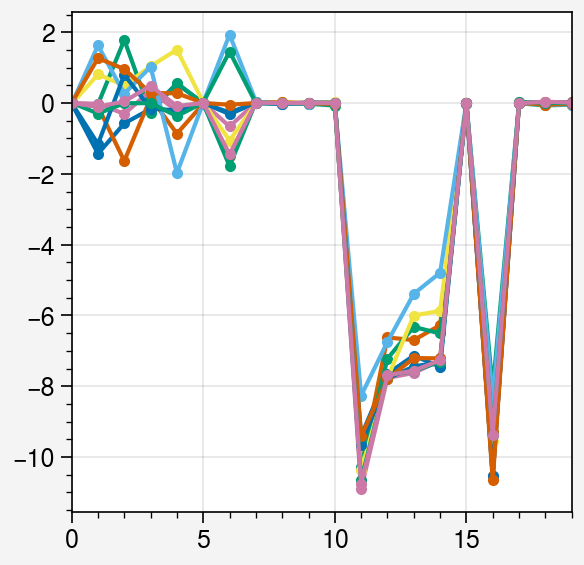

In [35]:
f2,a2 = pplt.subplots()
a2.plot(np.asarray(encs).T,'.-')

In [ ]:
#need to look into the traverse mode a little more carefully. Suggest to initiate the solver class
#and overwrite the net model 